<a href="https://colab.research.google.com/github/wonkwonlee/likelion-k-digital-training-AI/blob/main/Python-and-Data-Visualization/tensorflow_hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4" 
model = tf.keras.Sequential([
                             hub.KerasLayer(handle=mobile_net_url, input_shape=(224, 224, 3), trainable=False) ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


In [ ]:
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()
tf.keras.utils.plot_model(mobilev2)

In [5]:
import os
import pathlib
content_data_url = '/content/sample_data' 
# 원본 데이터 URL
data_root_orig = tf.keras.utils.get_file('imagenetV2',
                                         'https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-top-images.tar.gz',
                                         cache_dir=content_data_url, extract=True) 
# 저장 경로 설정
data_root = pathlib.Path(content_data_url + '/datasets/imagenetv2-top-images-format-val')
print(data_root)
for idx, item in enumerate(data_root.iterdir()): 
  print(item)
  if idx == 9: 
    break

1245929472/1245927936 [==============================] - 72s 0us/step
/content/sample_data/datasets/imagenetv2-top-images-format-val
/content/sample_data/datasets/imagenetv2-top-images-format-val/679
/content/sample_data/datasets/imagenetv2-top-images-format-val/412
/content/sample_data/datasets/imagenetv2-top-images-format-val/668
/content/sample_data/datasets/imagenetv2-top-images-format-val/728
/content/sample_data/datasets/imagenetv2-top-images-format-val/995
/content/sample_data/datasets/imagenetv2-top-images-format-val/152
/content/sample_data/datasets/imagenetv2-top-images-format-val/802
/content/sample_data/datasets/imagenetv2-top-images-format-val/561
/content/sample_data/datasets/imagenetv2-top-images-format-val/425
/content/sample_data/datasets/imagenetv2-top-images-format-val/119


In [8]:
# Load label data
label_file = tf.keras.utils.get_file(fname = 'label', origin = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

label_text = None
with open(label_file,'r') as f:
  label_text = f.read().split('\n')[:-1]

# Before data preprocessing
print(len(label_text)) 
print(label_text[:10]) 
print(label_text[-10:])

# Download wordnet from nltk
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

# After data preprocessing 
# Change to lower case and replace -, _, " " to ""
label_text = [c.lower().replace('-','').replace('_','').replace(' ','') for c in label_text] 
print(label_text[:10])
print(label_text[-10:])

16384/10484 [==============================================] - 0s 0us/step
1001
['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen']
['buckeye', 'coral fungus', 'agaric', 'gyromitra', 'stinkhorn', 'earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
['background', 'tench', 'goldfish', 'greatwhiteshark', 'tigershark', 'hammerhead', 'electricray', 'stingray', 'cock', 'hen']
['buckeye', 'coralfungus', 'agaric', 'gyromitra', 'stinkhorn', 'earthstar', 'henofthewoods', 'bolete', 'ear', 'toilettissue']


데이터 전처리는 자연어 처리에 있어 필수적이다.

image_count: 10000


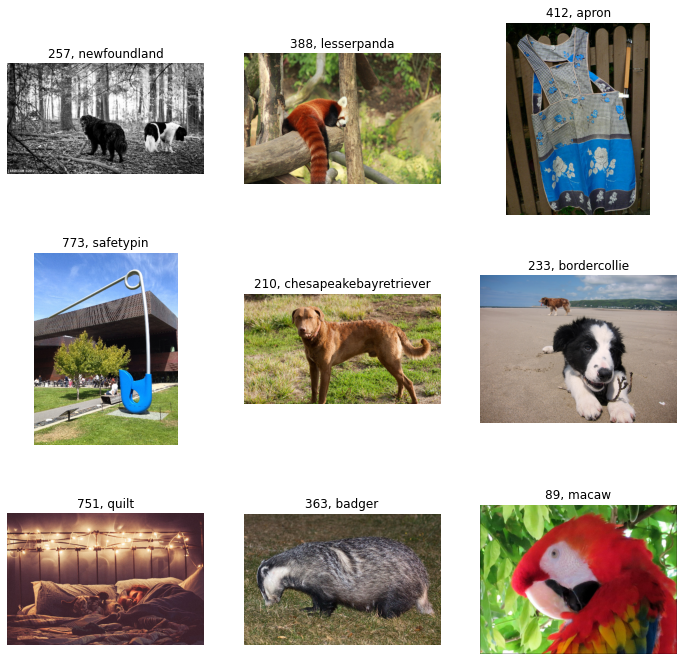

In [11]:
import PIL.Image as Image
import matplotlib.pyplot as plt
import random

# */*: 모든 경로 및 파일
all_image_paths = list(data_root.glob('*/*')) 
all_image_paths = [str(path) for path in all_image_paths]

random.shuffle(all_image_paths) 

image_count = len(all_image_paths)
print('image_count:', image_count)

plt.figure(figsize=(12,12)) 
for c in range(9):
  image_path = random.choice(all_image_paths) 
  plt.subplot(3,3,c+1) 
  plt.imshow(plt.imread(image_path))
  idx = int(image_path.split('/')[-2]) + 1
  plt.title(str(idx) + ', ' + label_text[idx])
  plt.axis('off') 
plt.show()

In [12]:
import cv2
import numpy as np

top_1 = 0 
top_5 = 0

for image_path in all_image_paths[:]:
  # cv2.imread() : Read image
  img = cv2.imread(image_path)
  # cv2.resize() : Resize images (pixel)
  img = cv2.resize(img, dsize=(224, 224))
  # Normalization (Max pixel = 255)
  img = img / 255.0
  # np.expand_dims( axis = 0 ) : 첫 번째 차원 추가 
  img = np.expand_dims(img, axis=0)

  top_5_predict = model.predict(img)[0].argsort()[::-1][:5]

  idx = int(image_path.split('/')[-2])+1
  if idx in top_5_predict:
    top_5 += 1
    if top_5_predict[0] == idx:
      top_1 += 1

print('TOP - 5 정확성 :', top_5 / len(all_image_paths) * 100, '%') 
print('TOP - 1 정확성 :', top_1 / len(all_image_paths) * 100, '%')

KeyboardInterrupt: ignored

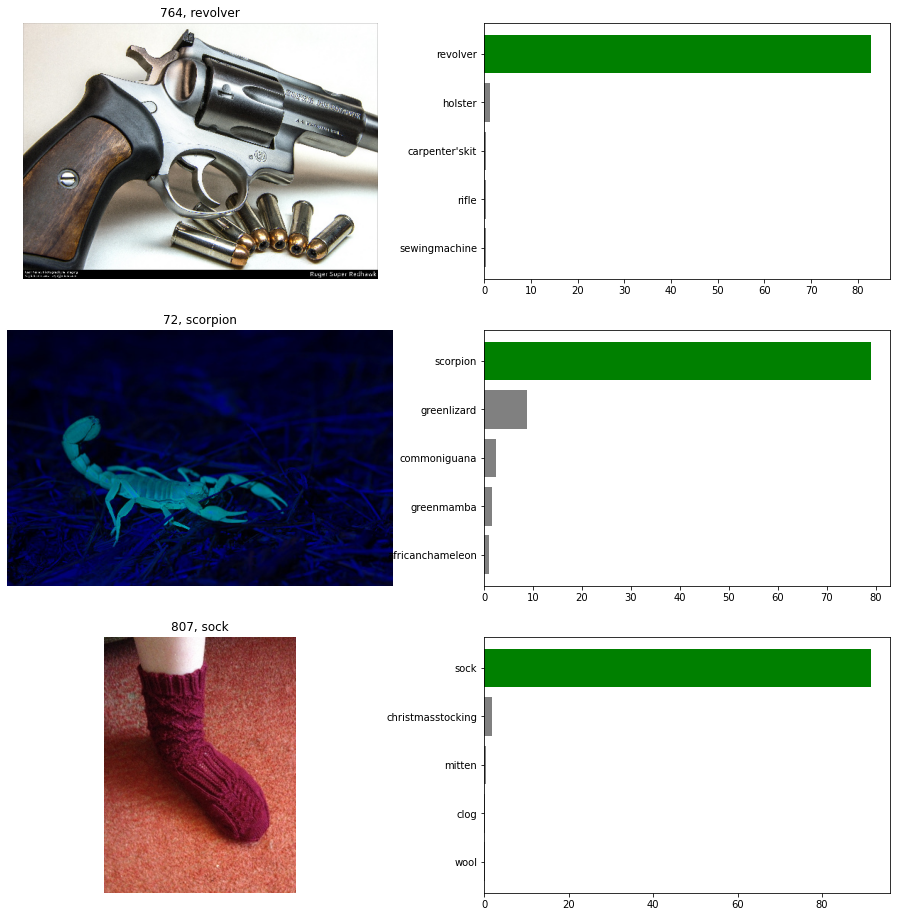

In [18]:
# MobileNet의 분류 및 실제 결과 확인

plt.figure(figsize=(16,16)) 
def softmax(x):
    max_elem = np.max(x)
    diff = (x - max_elem)
    exp = np.exp(diff)
    sum_exp = np.sum(exp)
    probs = (exp / sum_exp)
    return probs

for c in range(3):
  image_path = random.choice(all_image_paths)
  
  plt.subplot(3,2,c*2+1) 
  plt.imshow(plt.imread(image_path))
  idx = int(image_path.split('/')[-2]) + 1
  plt.title(str(idx) + ', ' + label_text[idx])
  plt.axis('off')
  plt.subplot(3,2,c*2+2)
  img = cv2.imread(image_path)
  img = cv2.resize(img, dsize=(224, 224)) 
  img = img / 255.0
  img = np.expand_dims(img, axis=0)

  logits = model.predict(img)[0]
  prediction = softmax(logits)

  top_5_predict = prediction.argsort()[::-1][:5]
 
  labels = [label_text[index] for index in top_5_predict]
  color = ['gray'] * 5

  if idx in top_5_predict: 
    color[top_5_predict.tolist().index(idx)] = 'green'
  color = color[::-1]
  plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color) 
  plt.yticks(range(5), labels[::-1])